In [75]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from data_loader import PrepareDataset
from model import SentimentClassifier

import logging
logging.basicConfig(level=logging.ERROR)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [76]:
# df = pd.read_csv("data/google_play/reviews.csv")
# df = df.rename({'content': 'text', 'score':'rating'}, axis=1)
df = pd.read_csv("data/yelp/reviews.csv")
df = df.rename({'stars': 'rating'}, axis=1)
df.head()

,Unnamed: 0,date,rating,text
0,0,2015-04-15 05:21:16,2.0,"As someone who has worked with many museums, I..."
1,1,2013-12-07 03:16:52,1.0,I am actually horrified this place is still in...
2,2,2015-12-05 03:18:11,5.0,I love Deagan's. I do. I really do. The atmosp...
3,3,2011-05-27 05:30:52,1.0,"Dismal, lukewarm, defrosted-tasting TexMex glo..."
4,4,2017-01-14 21:56:57,4.0,"Oh happy day, finally have a Canes near my cas..."


In [77]:
df.shape

(19999, 4)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19999 non-null  int64  
 1   date        19999 non-null  object 
 2   rating      19999 non-null  float64
 3   text        19999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 625.1+ KB


/home/muzamil/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


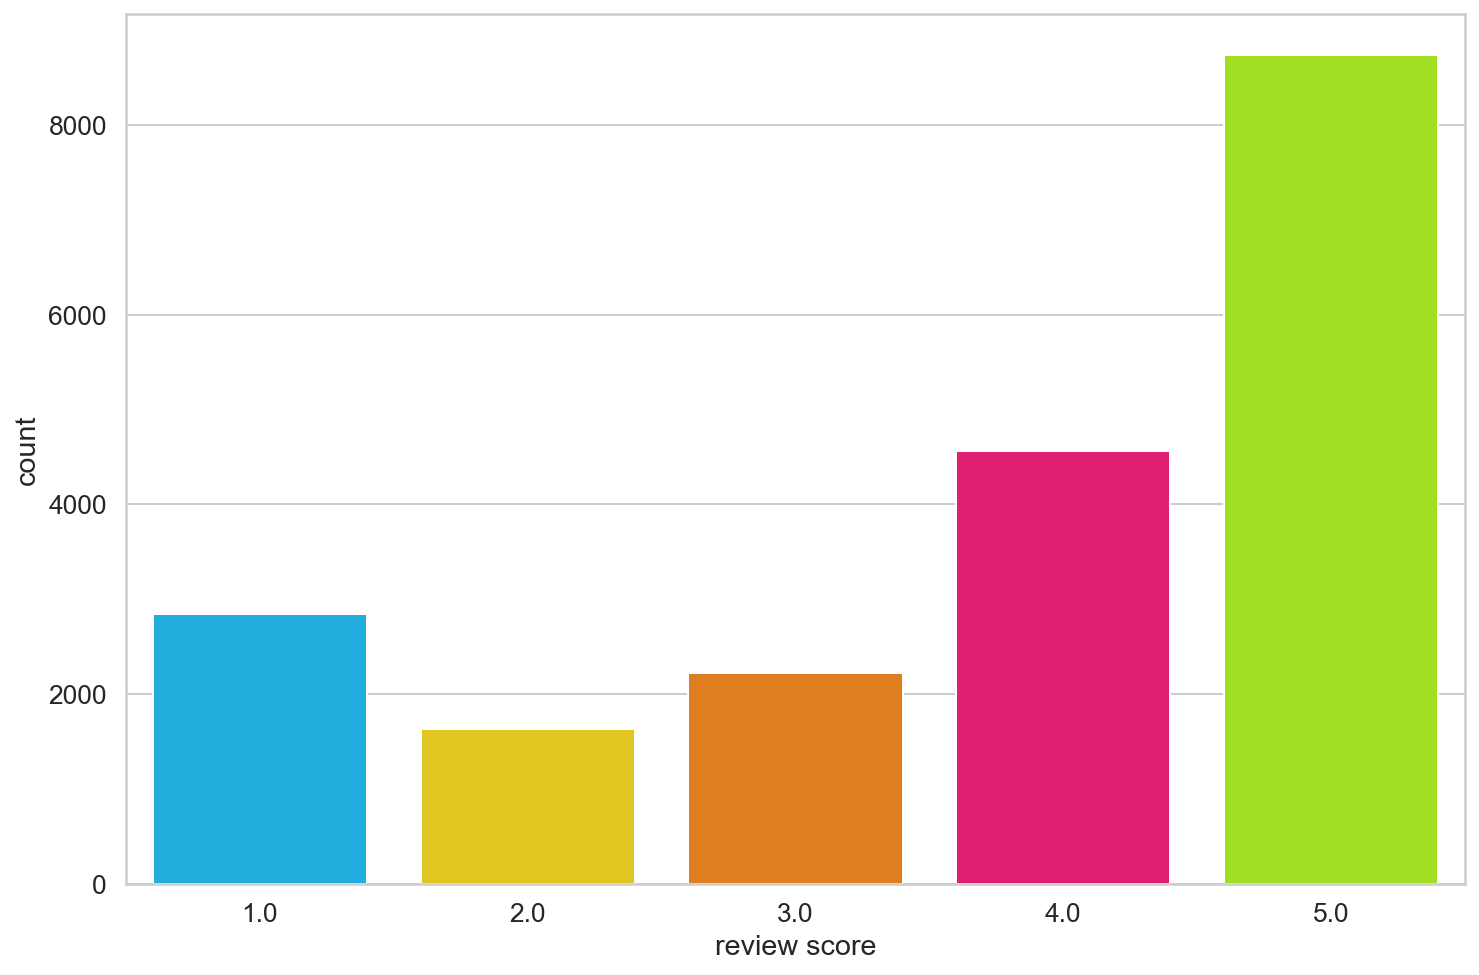

In [79]:
sns.countplot(df.rating)
plt.xlabel('review score');

In [83]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 3:
    return 0
  elif rating == 4:
    return 1
  else:
    return 2

df['sentiment'] = df.rating.apply(to_sentiment)

In [84]:
sentiments = ['negative', 'neutral', 'positive']

/home/muzamil/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


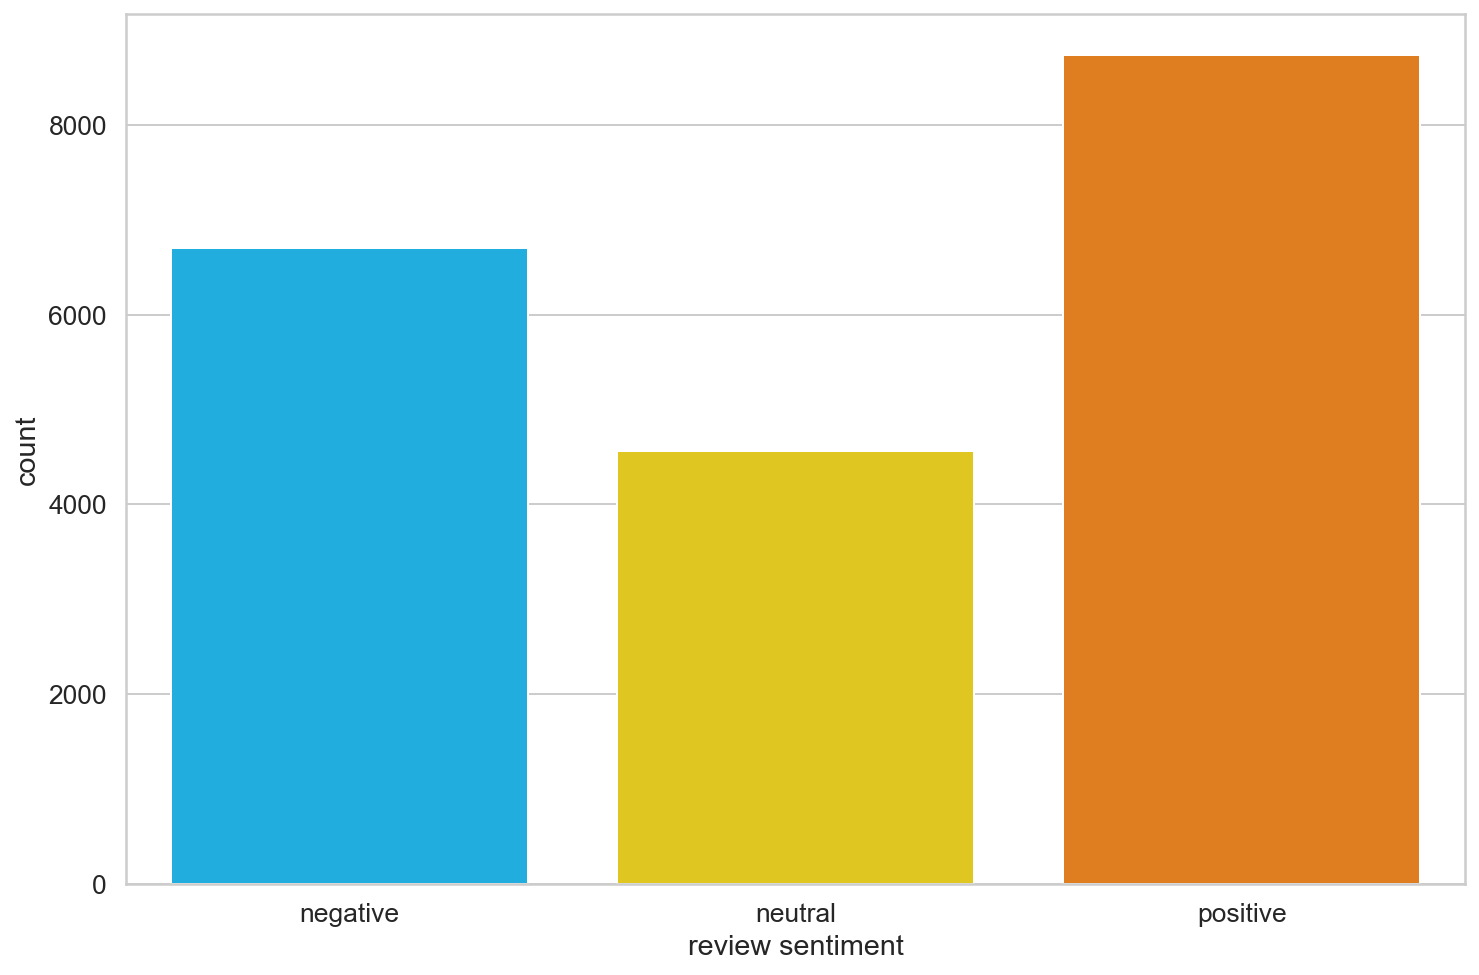

In [85]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(sentiments);

In [86]:
PRE_TRAINED_BERT_MODEL = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_BERT_MODEL)

/home/muzamil/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


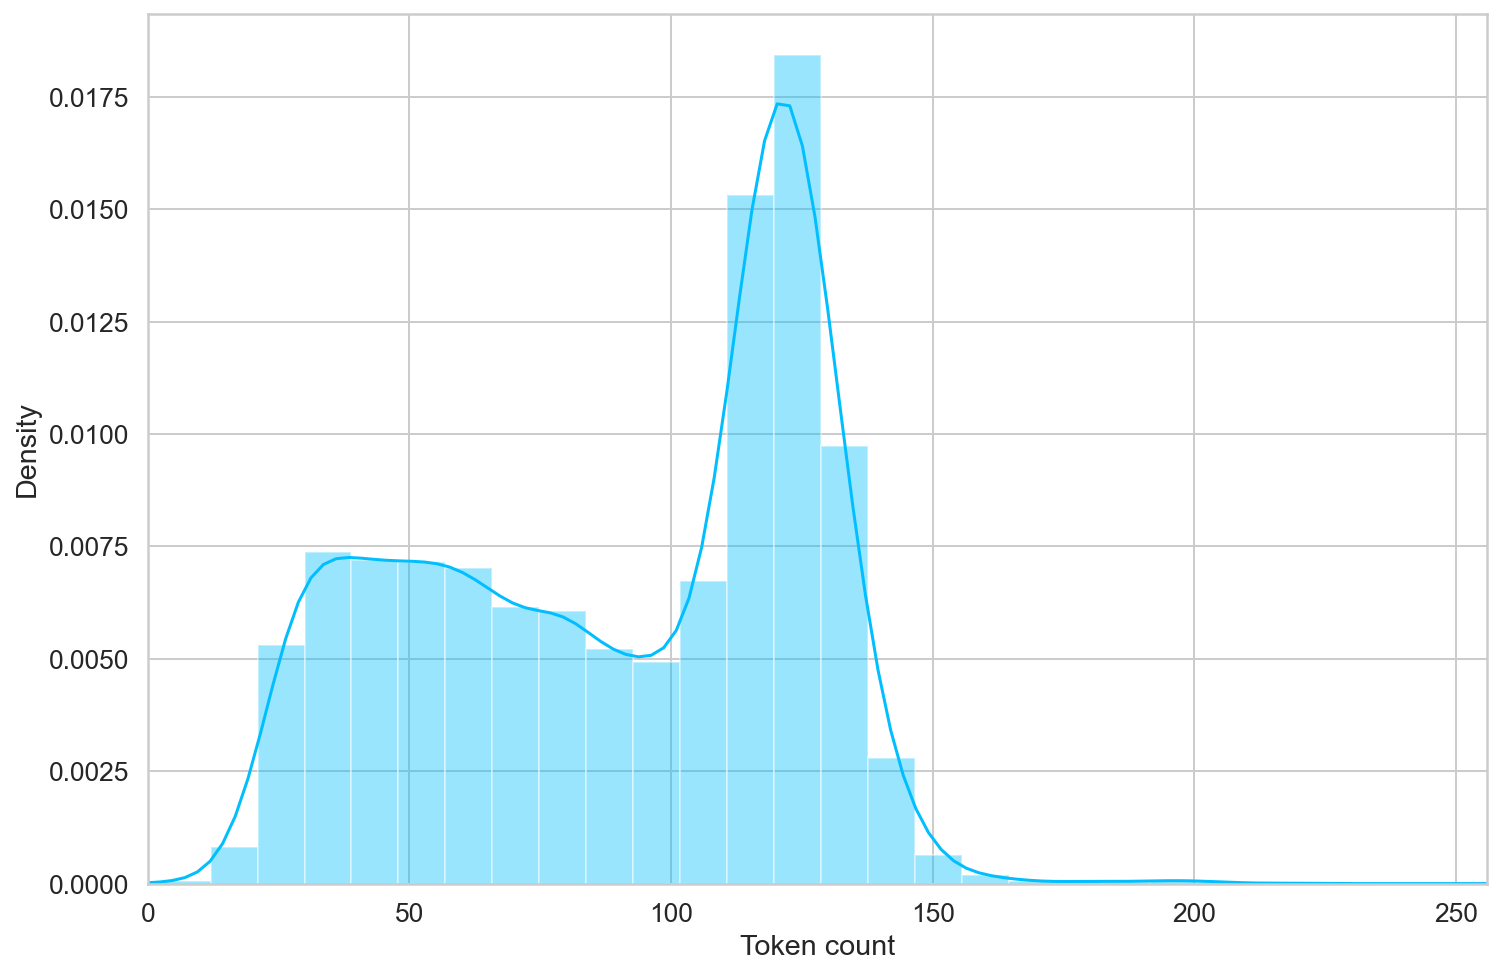

In [87]:
token_lens = []

for text in df.text:
  tokens = tokenizer.encode(text, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [88]:
MAX_LEN = 160

In [89]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [90]:
df_train.shape, df_val.shape, df_test.shape

((17999, 5), (1000, 5), (1000, 5))

In [91]:
def create_data_loader(df, tokenizer, max_len, bs):
    ds = PrepareDataset(
        reviews=df["text"].to_numpy(),
        targets=df["sentiment"].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=bs, num_workers=4)

In [92]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [93]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [94]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [95]:
model = SentimentClassifier(PRE_TRAINED_BERT_MODEL, len(sentiments))
model = model.to(device)

In [96]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(targets.shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [97]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [98]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [99]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [100]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6432836941348182 accuracy 0.7201511195066392
Val   loss 0.559965714339226 accuracy 0.744

Epoch 2/10
----------
Train loss 0.4404999771018823 accuracy 0.8218234346352575
Val   loss 0.6387954940871586 accuracy 0.747

Epoch 3/10
----------
Train loss 0.30167894969218306 accuracy 0.8928829379409967
Val   loss 0.8711256829519121 accuracy 0.726

Epoch 4/10
----------
Train loss 0.22247904135079846 accuracy 0.9296072004000222
Val   loss 1.0680668707937002 accuracy 0.728

Epoch 5/10
----------
Train loss 0.1603876303436959 accuracy 0.9554975276404245
Val   loss 1.3535771932903795 accuracy 0.721

Epoch 6/10
----------
Train loss 0.12492692004162301 accuracy 0.9676648702705706
Val   loss 1.5260661568063947 accuracy 0.735

Epoch 7/10
----------
Train loss 0.08450687795574777 accuracy 0.9804433579643314
Val   loss 1.7807937473047613 accuracy 0.729

Epoch 8/10
----------
Train loss 0.06992896628219428 accuracy 0.9844435801989
Val   loss 1.7961964217700168 accurac

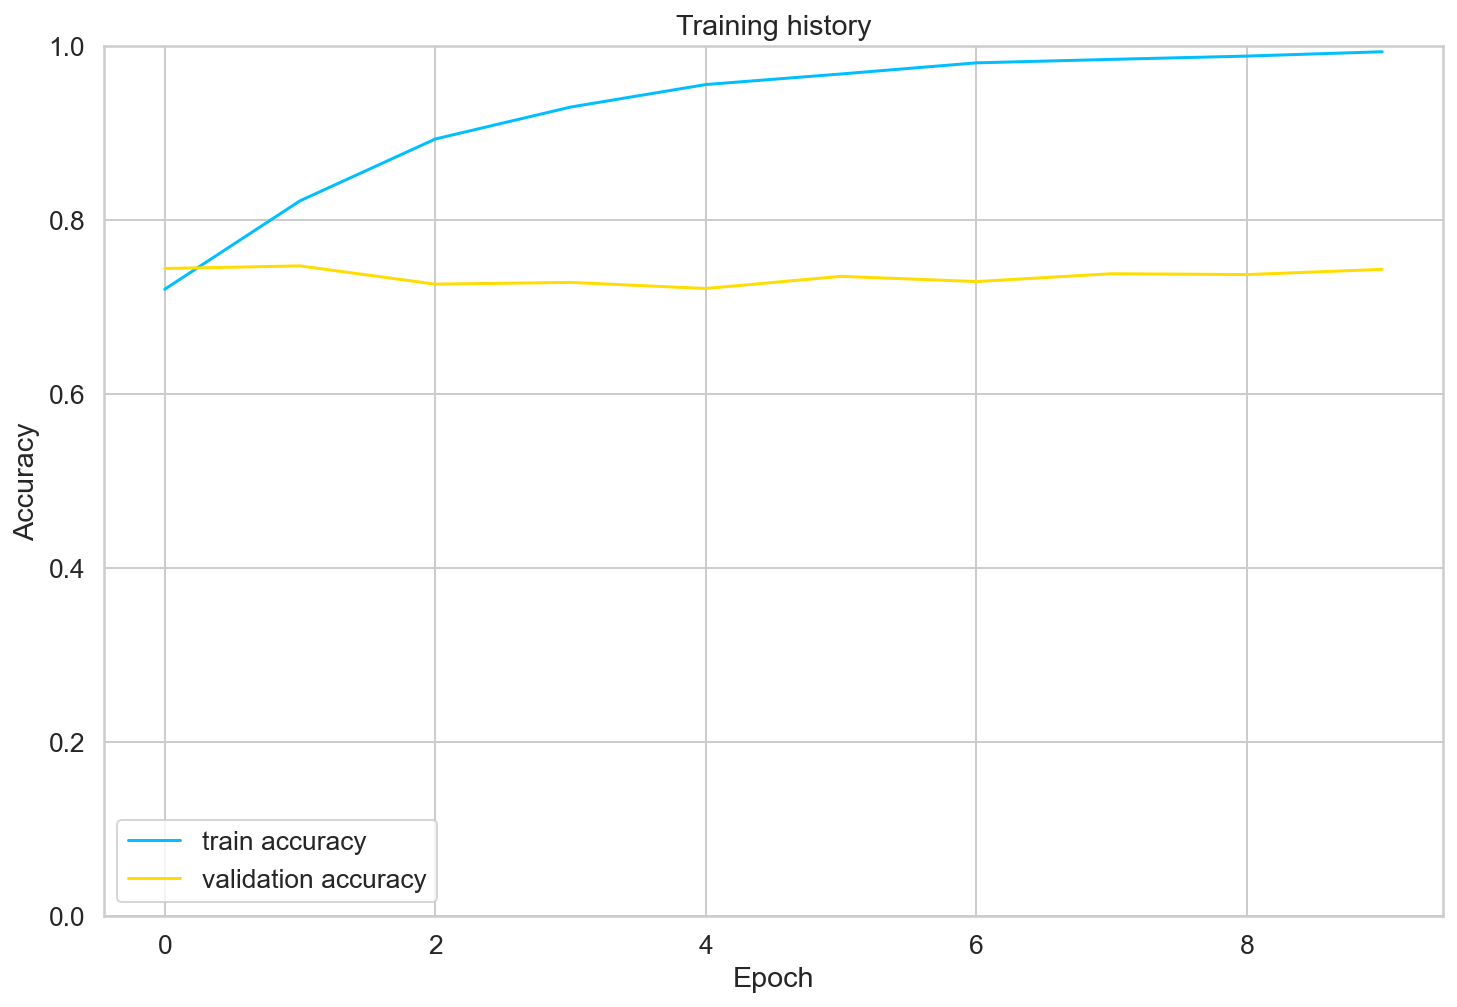

In [101]:
train_accuracy = torch.stack(history['train_acc'])
val_accuracy = torch.stack(history['val_acc'])
plt.plot(train_accuracy.cpu().numpy(), label='train accuracy')
plt.plot(val_accuracy.cpu().numpy(), label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# model = SentimentClassifier(PRE_TRAINED_BERT_MODEL, len(sentiments))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [102]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.745

In [103]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [104]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [105]:
print(classification_report(y_test, y_pred, target_names=sentiments))

              precision    recall  f1-score   support

    negative       0.85      0.82      0.84       329
     neutral       0.49      0.54      0.51       228
    positive       0.81      0.80      0.80       443

    accuracy                           0.74      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.75      0.74      0.75      1000



In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
evaluate_roc(y_pred_probs, y_test)

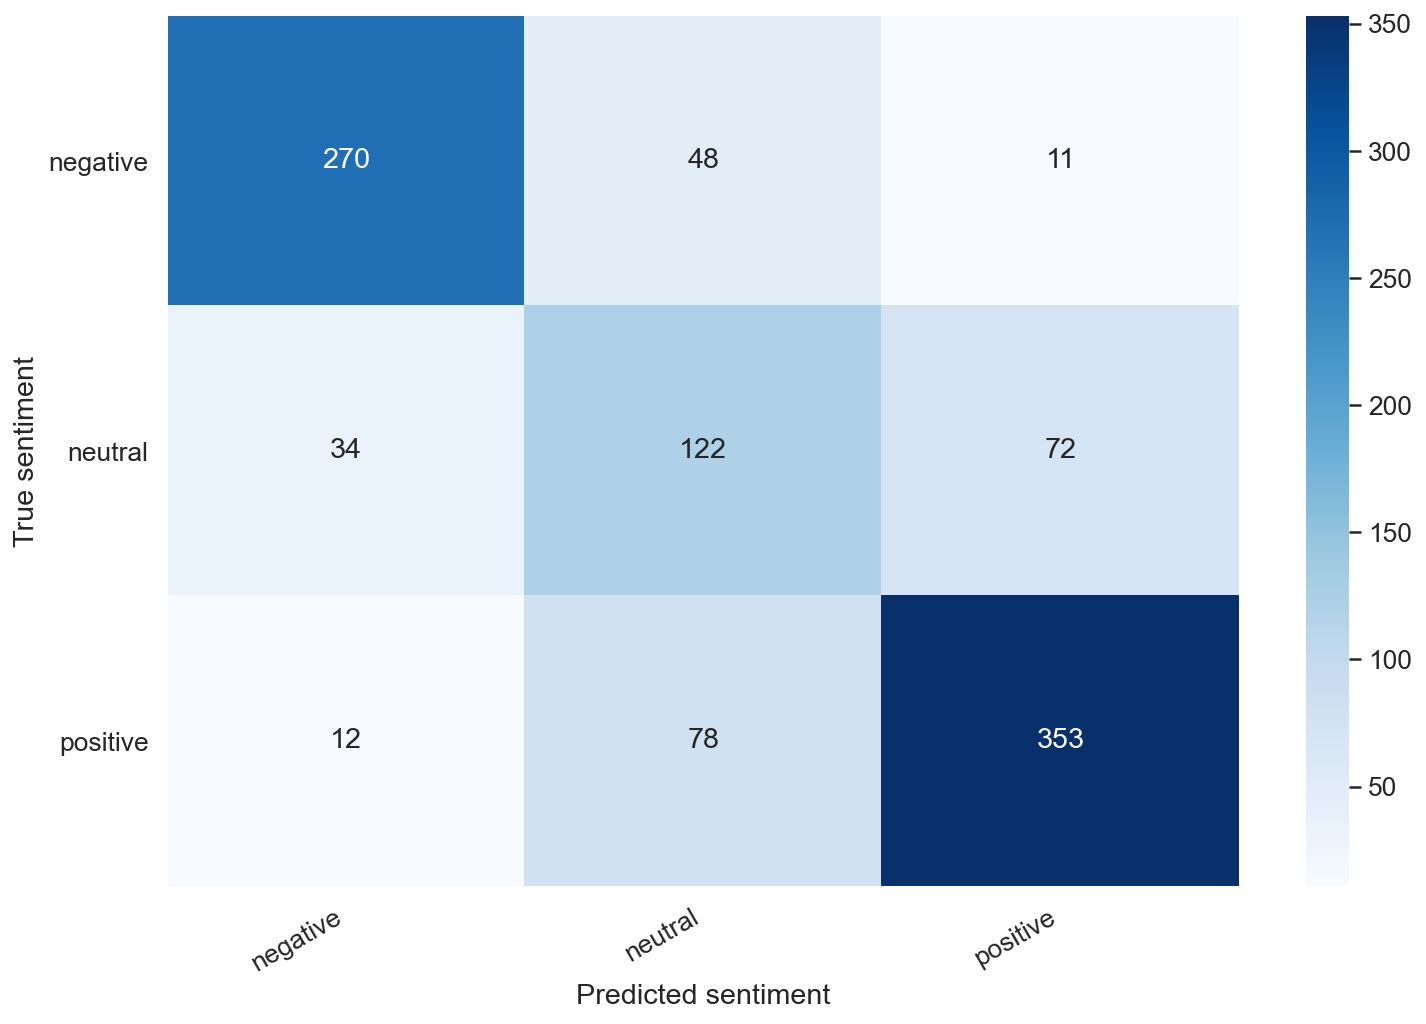

In [106]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=sentiments, columns=sentiments)
show_confusion_matrix(df_cm)

In [107]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'sentiments': sentiments,
  'values': y_pred_probs[idx]
})

In [108]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {sentiments[true_sentiment]}')

This food is delicious and its authentic. The owner sticks by his word
and makes sure his customers are satisfied. This is one of the only
Greek places that has authentic tzatziki sauce. I eat here at least 3
times a week. This place is a hidden gem I'm the university circle
Uptown district. If eating in this area be sure to shop by this place.
P.S the chicken wings are to die for literally. Im a life time
customer.

True sentiment: positive


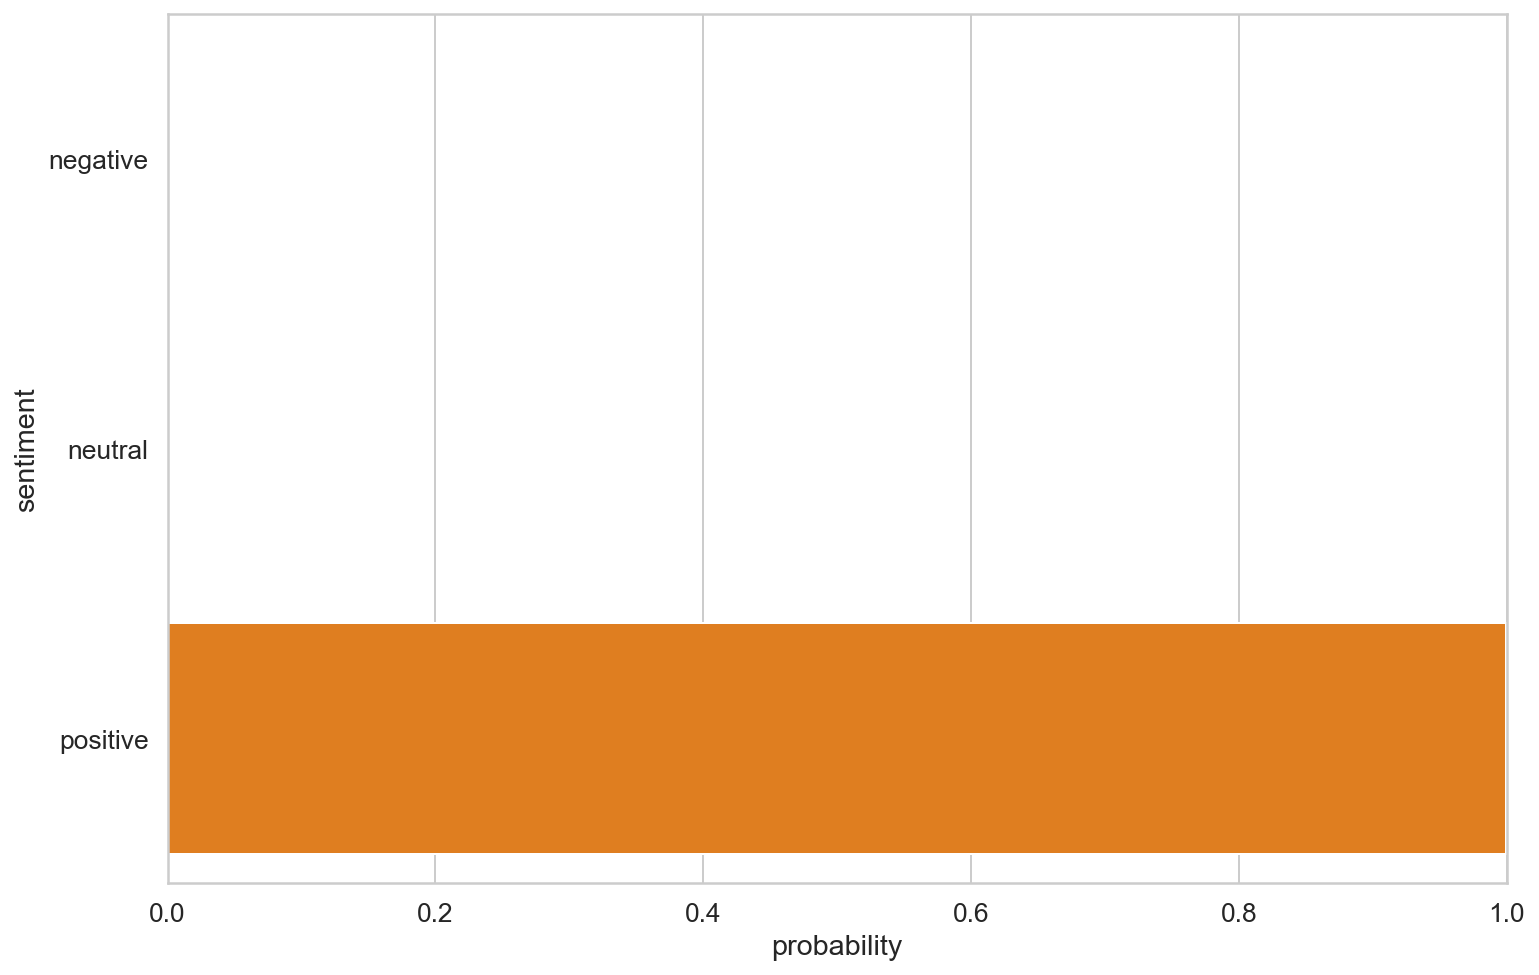

In [109]:
sns.barplot(x='values', y='sentiments', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [110]:
review_text = "I love completing my todos! Best app ever!!!"

In [111]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [112]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {sentiments[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
